![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Final Project: Contextual Bandits - Synthetic Benchmarking*

## Reinforcement Learning

#### Authors: **Timothy Cassel, Marvin Ernst, Oliver Tausendschön**

Date: July 2, 2025

Instructors: *Hamish Flynn and Vincent Adam*

In this notebook, we design and analyze contextual bandit policies in a **controlled synthetic environment**.

Unlike earlier offline evaluations with logged Open Bandit data, we now use **synthetic data with ground truth**, which allows us to:
- Directly measure **regret** and **cumulative reward**
- Simulate **online learning** over multiple rounds
- Evaluate **LinUCB** and **Thompson Sampling** under simplified but interpretable conditions

The synthetic setup ensures:
- **Moderate context dimension** (e.g. 5)
- **Multiple arms** (e.g. 5–10)
- **Non-sparse rewards**, for effective learning
- Fully known reward function, enabling regret computation

We use both custom generation and `obp.dataset.SyntheticBanditDataset` to simulate realistic but tractable learning environments.

---

### 1. Imports and Setup

In [12]:
# General 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# obp imports 
from obp.dataset import SyntheticBanditDataset, logistic_reward_function
from obp.policy import LinTS, LinUCB, LinEpsilonGreedy

from obp.ope import OffPolicyEvaluation, ReplayMethod, DoublyRobust
from obp.simulator import calc_ground_truth_policy_value, run_bandit_simulation

import warnings
warnings.filterwarnings('ignore')

**Synthetic Dataset Setup**

In [13]:
n_rounds = 3000
n_actions = 5
context_dim = 5
random_state = 42

dataset = SyntheticBanditDataset(
    n_actions=n_actions,
    dim_context=context_dim,
    reward_function=logistic_reward_function,
    behavior_policy_function=None,
    random_state=random_state,
)

bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

### 2. Dataset Exploration

In [14]:
print("Average reward:", bandit_feedback['reward'].mean())
print("Context shape:", bandit_feedback['context'].shape)

Average reward: 0.57
Context shape: (3000, 5)


##### **Context**

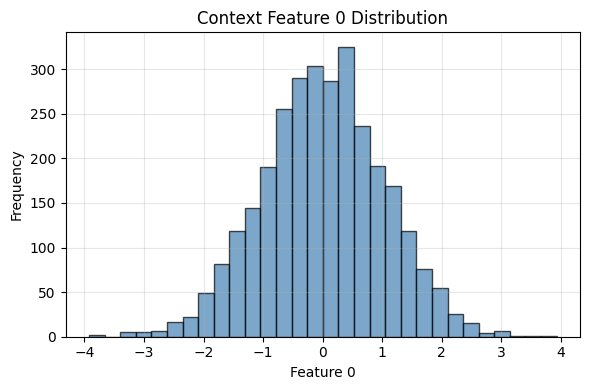

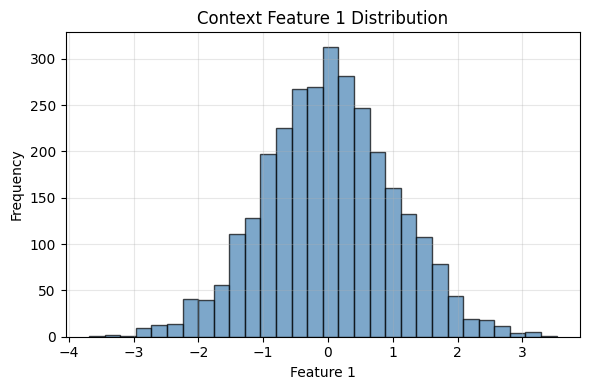

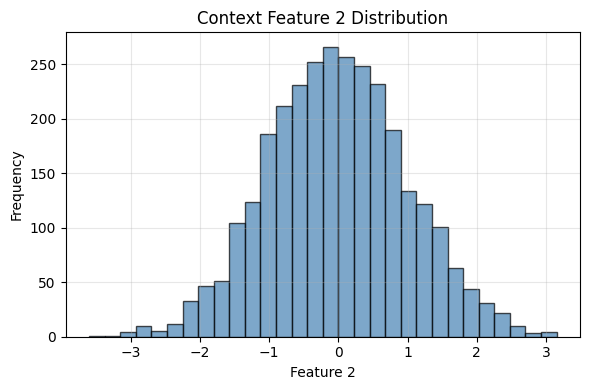

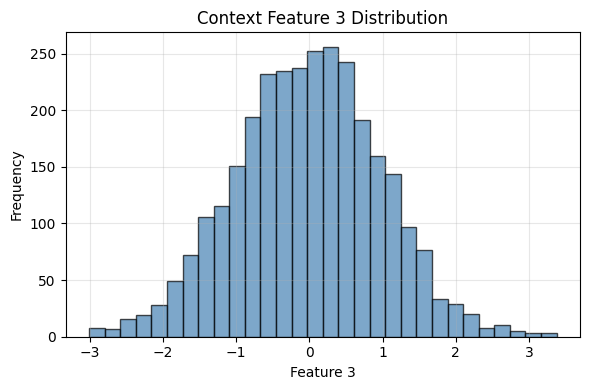

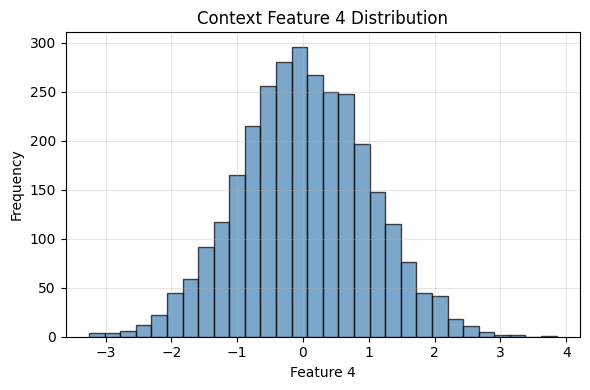

In [15]:
context = bandit_feedback["context"]
context_dim = context.shape[1]

for i in range(context_dim):
    plt.figure(figsize=(6, 4))
    plt.hist(context[:, i], bins=30, alpha=0.7, color="steelblue", edgecolor="black")
    plt.title(f"Context Feature {i} Distribution")
    plt.xlabel(f"Feature {i}")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

##### **Rewards**

**Ground-truth reward probabilities:**

For each arm $a$, the dataset assigns a true parameter vector $\theta_a \in \mathbb{R}^d$ (where $d$ is the context dimension). Then, for each observation $t$, the reward is sampled as:

$$r_t \sim \text{Bernoulli}\left( \sigma(x_t^\top \theta_a) \right)$$

Where:
- $x_t$ is the context vector at time $t$,
- $\theta_a$ is the true weight vector for arm $a$,
- $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the logistic sigmoid.

Average reward per arm:

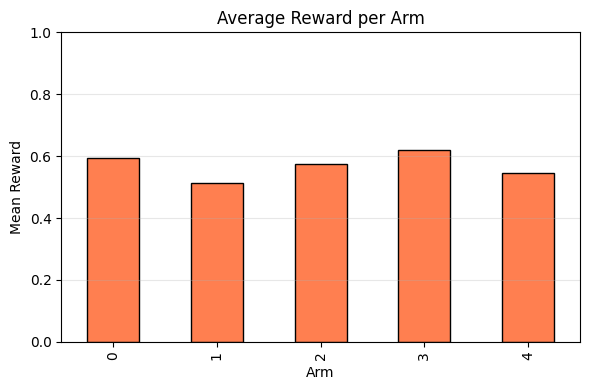

In [16]:
df = pd.DataFrame({
    "action": bandit_feedback["action"],
    "reward": bandit_feedback["reward"]
})
mean_rewards = df.groupby("action")["reward"].mean()

plt.figure(figsize=(6, 4))
mean_rewards.plot(kind="bar", color="coral", edgecolor="black")
plt.title("Average Reward per Arm")
plt.xlabel("Arm")
plt.ylabel("Mean Reward")
plt.ylim(0, 1)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 3. Define Evaluation Policies

We define several contextual bandit policies for offline evaluation. These include:
- LinUCB with varying exploration parameters (`alpha` values)
- Thompson Sampling (LinTS)
- Epsilon-Greedy baseline

First, we set dimensionality from the synthetic bandit feedback:

In [18]:
dim_context = bandit_feedback["context"].shape[1]
n_actions = len(np.unique(bandit_feedback["action"]))

Now, we define the policies:

In [19]:
policies = {
    'LinUCB_0.0': LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.0, random_state=123),
    'LinUCB_0.1': LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.1, random_state=123),
    'LinUCB_0.5': LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.5, random_state=123),
    'LinTS': LinTS(dim=dim_context, n_actions=n_actions, random_state=123),
    'LinEpsilonGreedy_0.1': LinEpsilonGreedy(dim=dim_context, n_actions=n_actions, epsilon=0.1, random_state=123),
}

## 4. Offline Evaluation (Replay / DR)

In this section, we evaluate our policies using **offline evaluation methods** on the synthetic bandit dataset. Since we have access to the **true reward function** in this setup, we can compute ground-truth policy values and compare them against:

- **Replay Method (RM)**: A simple but high-variance estimator that uses only logged actions matching the policy.
- **Doubly Robust (DR)**: A more stable and statistically efficient estimator that combines model-based reward predictions with observed data.

We report per-policy estimates under both estimators and compare them to the true expected rewards.

Prepare estimated Q_hat and action distributions:

In [20]:
Q_hat = bandit_feedback['expected_reward']
action_distributions = {}

Compute action distributions for all policies:

In [21]:
for name, policy in policies.items():
    print(f"Simulating actions for {name}...")
    action_dist = run_bandit_simulation(
        bandit_feedback=bandit_feedback,
        policy=policy
    )
    action_distributions[name] = action_dist

Simulating actions for LinUCB_0.0...


100%|██████████| 3000/3000 [00:00<00:00, 7871.97it/s]


Simulating actions for LinUCB_0.1...


100%|██████████| 3000/3000 [00:00<00:00, 10448.19it/s]


Simulating actions for LinUCB_0.5...


100%|██████████| 3000/3000 [00:00<00:00, 9744.59it/s] 


Simulating actions for LinTS...


100%|██████████| 3000/3000 [00:03<00:00, 829.41it/s] 


Simulating actions for LinEpsilonGreedy_0.1...


100%|██████████| 3000/3000 [00:00<00:00, 11453.57it/s]


Ensure compatibility of shapes for OPE:

In [22]:
def fix_shapes(action_dist, Q_hat):
    if Q_hat.ndim == 2:
        Q_hat = np.expand_dims(Q_hat, axis=2)
    if action_dist.ndim == 2:
        action_dist = np.expand_dims(action_dist, axis=2)
    return action_dist, Q_hat

Evaluation:

In [23]:
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[ReplayMethod(), DoublyRobust()]
)

results = {}
for name, action_dist in action_distributions.items():
    print(f"Evaluating {name}...")
    action_dist_fixed, Q_hat_fixed = fix_shapes(action_dist, Q_hat)

    estimates = ope.estimate_policy_values(
        action_dist=action_dist_fixed,
        estimated_rewards_by_reg_model=Q_hat_fixed
    )
    results[name] = estimates

Evaluating LinUCB_0.0...
Evaluating LinUCB_0.1...
Evaluating LinUCB_0.5...
Evaluating LinTS...
Evaluating LinEpsilonGreedy_0.1...


**Results**

In [ ]:
ground_truth_values = {
    name: calc_ground_truth_policy_value(
        bandit_feedback=bandit_feedback,
        reward_sampler=dataset.sample_reward,
        policy=policies[name],
        n_sim=50
    )
    for name in policies
}

rows = []
for name in policies:
    row = {
        "Policy": name,
        "Ground Truth": ground_truth_values[name],
        "Replay Method": results[name]["rm"],
        "Doubly Robust": results[name]["dr"]
    }
    rows.append(row)

df_ope = pd.DataFrame(rows)
df_ope.sort_values("Ground Truth", ascending=False, inplace=True)

100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


ModuleNotFoundError: No module named 'ace_tools'

In [26]:
df_ope

,Policy,Ground Truth,Replay Method,Doubly Robust
1,LinUCB_0.1,0.681384,0.610561,0.607821
2,LinUCB_0.5,0.665537,0.602329,0.606540
0,LinUCB_0.0,0.659506,0.614379,0.614028
3,LinTS,0.655968,0.571664,0.578919
4,LinEpsilonGreedy_0.1,0.651902,0.609075,0.604566


## 5. Online Simulation

For the online learning simulation, we take advantage of the **known ground truth** in our synthetic dataset. Specifically, we know the expected reward of each arm given a context, which allows us to calculate:

- The **cumulative reward** received by a policy during online interaction.
- The **cumulative regret**, which is the difference between the reward of the optimal action and the action selected by the policy.

We simulate the online interaction for each policy over all rounds, where each policy:
1. Observes a context.
2. Selects an action based on its internal logic.
3. Receives a reward sampled from the true reward function.
4. Updates its parameters.

We begin by implementing the online simulation loop, where we simulate online learning using the true reward function.

In [27]:
def simulate_online_learning(policy, contexts, dataset, n_rounds):
    cumulative_rewards = np.zeros(n_rounds)
    regret = np.zeros(n_rounds)
    best_arm_rewards = np.zeros(n_rounds)

    for t in range(n_rounds):
        x = contexts[t].reshape(1, -1)

        # Select action using current policy
        a = policy.select_action(x)[0]

        # True expected reward for all arms
        expected_rewards = [
            dataset.sample_reward(x, np.array([a_i]))[0]
            for a_i in range(n_actions)
        ]
        best_reward = max(expected_rewards)
        actual_reward = expected_rewards[a]

        # Update policy
        policy.update_params(action=a, reward=actual_reward, context=x)

        # Track metrics
        cumulative_rewards[t] = cumulative_rewards[t - 1] + actual_reward if t > 0 else actual_reward
        regret[t] = regret[t - 1] + (best_reward - actual_reward) if t > 0 else (best_reward - actual_reward)
        best_arm_rewards[t] = best_reward

    return cumulative_rewards, regret

We define a random policy as baseline:

In [37]:
class RandomPolicy:
    def __init__(self, n_actions, random_state=None):
        self.n_actions = n_actions
        self.rng = np.random.default_rng(random_state)

    def select_action(self, x):
        return [self.rng.integers(0, self.n_actions)]

    def update_params(self, action, reward, context):
        pass  # No learning for random policy

New helper for new policies:

In [38]:
def create_policy(name, dim_context, n_actions, random_state=123):
    if name == 'LinUCB_0.0':
        return LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.0, random_state=random_state)
    elif name == 'LinUCB_0.1':
        return LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.1, random_state=random_state)
    elif name == 'LinUCB_0.5':
        return LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.5, random_state=random_state)
    elif name == 'LinTS':
        return LinTS(dim=dim_context, n_actions=n_actions, random_state=random_state)
    elif name == 'LinEpsilonGreedy_0.1':
        return LinEpsilonGreedy(dim=dim_context, n_actions=n_actions, epsilon=0.1, random_state=random_state)
    elif name == 'Random':
        return RandomPolicy(n_actions=n_actions, random_state=random_state)
    else:
        raise ValueError(f"Unknown policy name: {name}")

Now, we runit for all policies:

In [39]:
online_results = {}
contexts = bandit_feedback["context"]
n_rounds = contexts.shape[0]

for name in list(policies.keys()) + ["Random"]:
    print(f"Simulating online learning for: {name}")
    fresh_policy = create_policy(name, dim_context, n_actions, random_state=123)
    cum_rewards, regrets = simulate_online_learning(fresh_policy, contexts, dataset, n_rounds)
    online_results[name] = {
        "rewards": cum_rewards,
        "regrets": regrets
    }

Simulating online learning for: LinUCB_0.0
Simulating online learning for: LinUCB_0.1
Simulating online learning for: LinUCB_0.5
Simulating online learning for: LinTS
Simulating online learning for: LinEpsilonGreedy_0.1
Simulating online learning for: Random


#### *Online Learning Results*

We now plot the cumulative **reward** and **regret** curves for each policy to evaluate their learning performance over time. Lower regret and higher reward indicate better learning.

**Cumulative Reward**

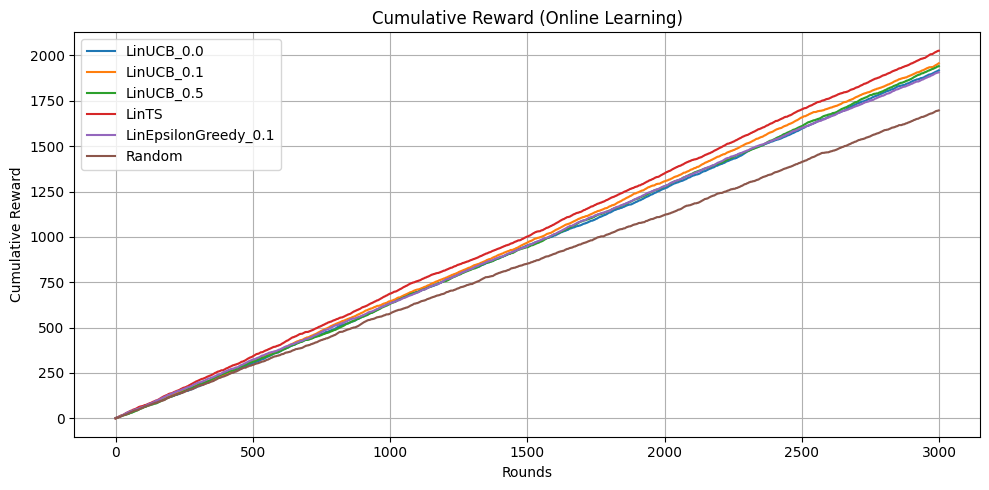

In [40]:
plt.figure(figsize=(10, 5))
for name, res in online_results.items():
    plt.plot(res["rewards"], label=name)
plt.title("Cumulative Reward (Online Learning)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Cumulative Regret**

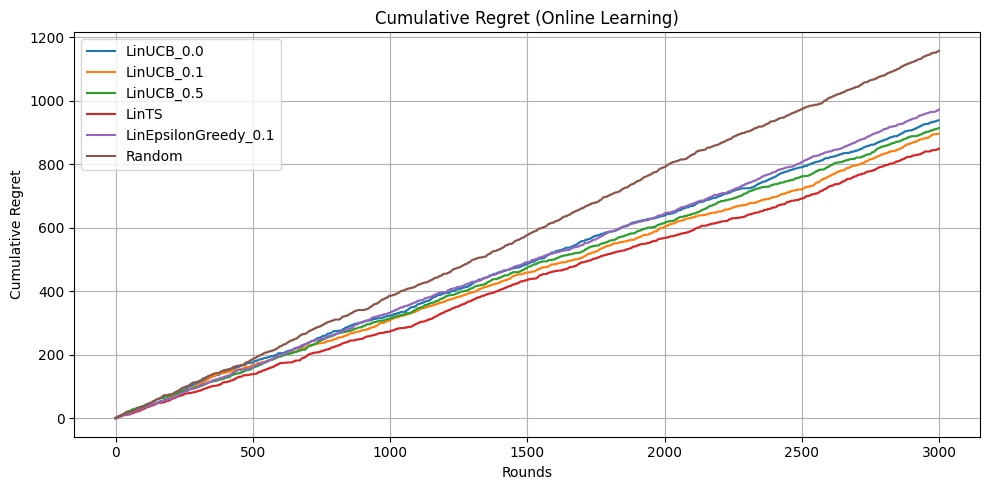

In [41]:
plt.figure(figsize=(10, 5))
for name, res in online_results.items():
    plt.plot(res["regrets"], label=name)
plt.title("Cumulative Regret (Online Learning)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Averaged Online Evaluation

To reduce the variance of individual runs, we now repeat the online simulation **across 30 different seeds**. In each run, we:
- Re-sample the dataset using the same synthetic data generator.
- Create a **fresh instance** of each policy.
- Simulate online learning over all rounds.
- Track and average both **cumulative rewards** and **regrets**.

This allows us to estimate the **mean learning behavior** of each policy and compare them more reliably.

In [34]:
n_runs = 30
n_rounds = bandit_feedback['context'].shape[0]

Initialize averages and run evaluations:

In [42]:
avg_rewards = {**{name: np.zeros(n_rounds) for name in policies}, "Random": np.zeros(n_rounds)}
avg_regrets = {**{name: np.zeros(n_rounds) for name in policies}, "Random": np.zeros(n_rounds)}

print("Running averaged online simulation...")

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_function=logistic_reward_function,
        behavior_policy_function=None,
        random_state=run
    )
    bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)
    contexts = bandit_feedback['context']

    for name in list(policies.keys()) + ["Random"]:
        fresh_policy = create_policy(name, dim_context, n_actions, random_state=run)
        cum_rewards, regrets = simulate_online_learning(fresh_policy, contexts, dataset, n_rounds)
        avg_rewards[name] += cum_rewards
        avg_regrets[name] += regrets

Running averaged online simulation...
Run 1/30
Run 2/30
Run 3/30
Run 4/30
Run 5/30
Run 6/30
Run 7/30
Run 8/30
Run 9/30
Run 10/30
Run 11/30
Run 12/30
Run 13/30
Run 14/30
Run 15/30
Run 16/30
Run 17/30
Run 18/30
Run 19/30
Run 20/30
Run 21/30
Run 22/30
Run 23/30
Run 24/30
Run 25/30
Run 26/30
Run 27/30
Run 28/30
Run 29/30
Run 30/30


Normalize:

In [43]:
for name in avg_rewards:
    avg_rewards[name] /= n_runs
    avg_regrets[name] /= n_runs

#### *Averaged Results*

Below we plot the **mean cumulative reward** and **mean cumulative regret** across 30 simulation runs.

This allows us to draw more robust conclusions about each policy’s effectiveness in online learning.

**Average Cumulative Reward**

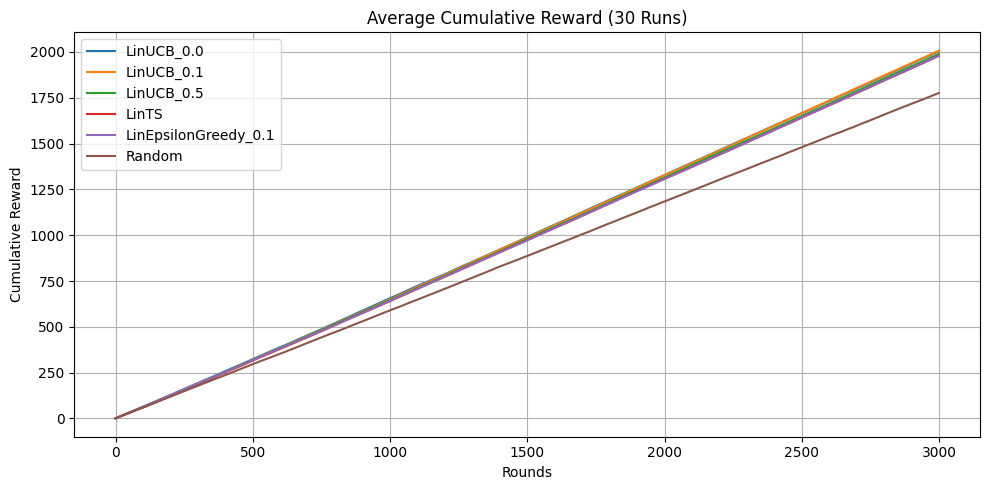

In [44]:
plt.figure(figsize=(10, 5))
for name in avg_rewards:
    plt.plot(avg_rewards[name], label=name)
plt.title("Average Cumulative Reward (30 Runs)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Average Cumulative Regret**

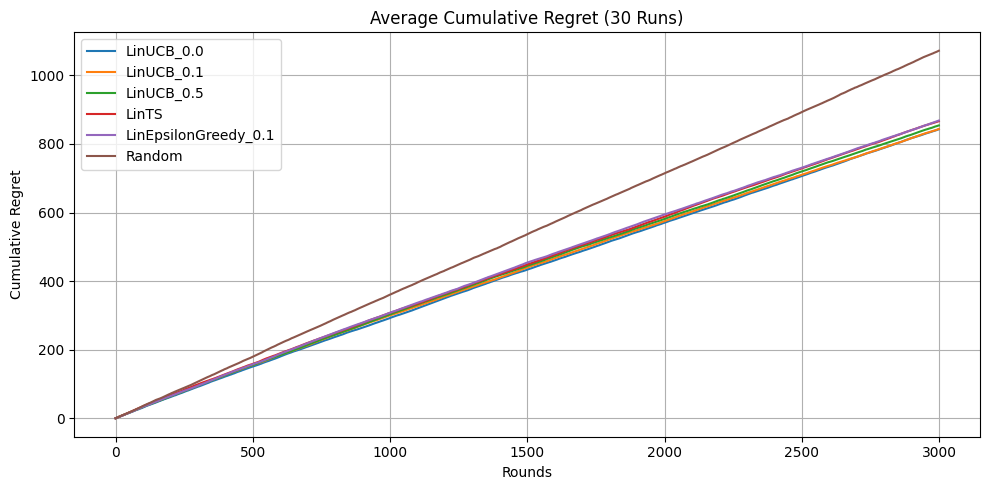

In [45]:
plt.figure(figsize=(10, 5))
for name in avg_regrets:
    plt.plot(avg_regrets[name], label=name)
plt.title("Average Cumulative Regret (30 Runs)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that they are all better than random, however, the difference ebtween the bandit algorithms itself is quiet small.